<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучить-данные" data-toc-modified-id="Изучить-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучить данные</a></span></li><li><span><a href="#Препроцессинг" data-toc-modified-id="Препроцессинг-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Препроцессинг</a></span></li></ul></div>

In [1]:
import spacy
import nltk
import pandas as pd
import numpy as np
import sys
import re
import gensim.models
from lightgbm import LGBMClassifier
# Импортируем метод word_tokenize из библиотеки nltk
from nltk.tokenize import word_tokenize 
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from tqdm import trange

Загружаем данные для проекта

In [49]:
train = pd.read_csv('E:\\Data\\_Projects\\datasets\\train.csv')
test = pd.read_csv('E:\\Data\\_Projects\\datasets\\test.csv')

In [3]:
train.head(10)

,text,Y
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
nlp =spacy.load('en_core_web_lg')

 ## Изучить данные

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   Y       159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
train['Y'].unique()

array([0, 1], dtype=int64)

In [7]:
train.isnull().sum()

text    0
Y       0
dtype: int64

In [8]:
pd.set_option('display.max_colwidth', None)
train.sample(5)

,text,Y
43382,They're both politically motivated (although with conflicting goals).,0
116834,"Tyus Jones \n\nI see you have taken a stab at the issue of Wikipedia:Administrators'_noticeboard#Recreation_of_thrice-CSDed_page, but while fixing one thing up you messed up another. (T / C / WP:FOUR / WP:CHICAGO / WP:WAWARD)",0
104430,Jimbo Wales \n\nStupid.,1
8832,"Saint Diablo copyright problems \nGreetings, I see that you have claimed on this article's website that the part of the article is copied with permission. However, the Wikipedia rules say that there are only 2 ways to give permission:\n Place a note on the website that use under the GFDL license is permitted. The note at doesn't specify this.\n Get a note sent to Wikipedia from an email identified with the copyright owner that they release this content under the GFDL.\n\nSee Wikipedia:Requesting copyright permission for details. I hope this can be resolved soon!",0
97821,"I don't see the relevance of this section being alone so should it be merged with another? Also, in what context is this written? Is it from the first movie, second movie, book...or what? I recommend this for deletion",0


In [9]:
train=train.drop_duplicates()

In [10]:
train.shape

(159571, 2)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(train['text'])


CountVectorizer()

In [12]:
len(vect.get_feature_names())

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


189775

In [13]:
count = train['text'].str.split().apply(len).value_counts()
count.values.sum()

159571

In [51]:
print(train['Y'].value_counts())
print(test['Y'].value_counts())

0    144277
1     15294
Name: Y, dtype: int64
0    57888
1     6090
Name: Y, dtype: int64


In [17]:
from joblib import parallel_backend
import winsound

In [15]:
from imblearn.over_sampling import SMOTE

## Препроцессинг

В данном случае обращаемся к нашим первым вебинарам, заново обращаемся к модулю re и к библиотеке spacy.

• Какие символы можно убрать, а какие нет

• Убрать лишние пробелы  

• Stop-слова, заимствовать из spacy или написать свой личный отбор

• Лемматизация, вспомнить почему лучше не использовать стемминг в данном случае 

• Подумать над другими возможными гипотезами

• Обернуть весь pipeline в одну функцию

In [16]:
# Функция для очистки текста от лишних символов
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # регулярное выражение для пунктуации
    regular_punkt=r'!"#$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # удаляем пунктуацияю
    text = re.sub(regular_punkt, '', text)
    text = re.sub("!", '', text)
    # возвращаем очищенные данные
    return text

In [18]:
with parallel_backend('threading', n_jobs=-1):
    train['text'] = train['text'].progress_apply(lambda x: clean_text(x))
    test['text']=test['text'].progress_apply(lambda x: clean_text(x))


100%|█████████████████████████████████████████████████████████████████████████| 63978/63978 [00:04<00:00, 14609.65it/s]


In [50]:
with parallel_backend('threading', n_jobs=-1):
    test['text']=test['text'].progress_apply(lambda x: clean_text(x))

100%|█████████████████████████████████████████████████████████████████████████| 63978/63978 [00:04<00:00, 14456.39it/s]


In [19]:
train.sample(3)

,text,Y
29661,that page was listed a couple of days ago but i didn't had time to check it anyway i see the problem is moot nowtizio,0
115092,hi wow you are such a geek bullshit mother fucker,1
13364,very useful suggestion it will be a welcome change to actually discuss it with some neutral folks thank you,0


with parallel_backend('threading', n_jobs=4):
    train['lemmas'] = train['text'].progress_apply(lambda x: lemmatize_text(x))
winsound.Beep(300,400)
train.sample(3)

# Stop words with no spacy

In [20]:
#Создадим список всех лемм из датасета
all_lemmas=[]
with parallel_backend('threading', n_jobs=-1):
    for i in trange(len(train['text'])):
        all_lemmas.append([token.lemma_ for token in nlp((train['text'][i]))])
winsound.Beep(300,400)

100%|█████████████████████████████████████████████████████████████████████████| 159571/159571 [17:44<00:00, 149.87it/s]


In [21]:
all_lemmas

[['explanation',
  'why',
  'the',
  'edit',
  'make',
  'under',
  'my',
  'username',
  'hardcore',
  'metallica',
  'fan',
  'be',
  'revert',
  'they',
  'be',
  'not',
  'vandalism',
  'just',
  'closure',
  'on',
  'some',
  'gas',
  'after',
  'I',
  'vote',
  'at',
  'new',
  'york',
  'dolls',
  'fac',
  'and',
  'please',
  'do',
  'not',
  'remove',
  'the',
  'template',
  'from',
  'the',
  'talk',
  'page',
  'since',
  'I',
  'be',
  'retire',
  'now',
  'NUM'],
 ["d'aww",
  'he',
  'match',
  'this',
  'background',
  'colour',
  'I',
  'be',
  'seemingly',
  'stuck',
  'with',
  'thank',
  'talk',
  'NUM',
  'january',
  'NUM',
  'utc'],
 ['hey',
  'man',
  'I',
  'be',
  'really',
  'not',
  'try',
  'to',
  'edit',
  'war',
  'it',
  'be',
  'just',
  'that',
  'this',
  'guy',
  'be',
  'constantly',
  'remove',
  'relevant',
  'information',
  'and',
  'talk',
  'to',
  'I',
  'through',
  'edit',
  'instead',
  'of',
  'my',
  'talk',
  'page',
  'he',
  'seem',
 

In [22]:
#объединим спиcок списков в один список
all_lemmas_full=[]
with parallel_backend('threading', n_jobs=-1):
    for i in all_lemmas:
        for j in i:
            all_lemmas_full.append(j)
winsound.Beep(300,400)

In [23]:
#Создадим словарь с частотой употребления каждой леммы
dict_f=pd.DataFrame(columns=['word'])
dict_f['word']=all_lemmas_full
w_count=dict_f['word'].value_counts()
w_count

be                527695
the               495521
to                297757
I                 274389
of                224027
                   ...  
obfuscator             1
agendawestboro         1
vandalonly             1
userhdt                1
ciu                    1
Name: word, Length: 201189, dtype: int64

In [24]:
#Отправим самые часто и самые редко -употребимые слова в стоп-лист
min_use=np.quantile(list(w_count.values),0.005)
max_use=np.quantile(list(w_count.values),0.995)

In [25]:
allowed_items=[]
not_allowed=[]
for word in w_count.index:
    if w_count[word]>min_use and w_count[word]<max_use:
        allowed_items.append(word)
    else:
        not_allowed.append(word)

In [26]:
print(not_allowed)

['be', 'the', 'to', 'I', 'of', 'and', 'you', 'a', 'that', 'not', 'it', 'in', 'NUM', 'have', 'do', 'for', 'this', 'on', 'as', 'article', 'your', 'with', 'if', 'page', 'or', 'but', ' ', 'my', 'an', 'they', 'can', 'from', 'by', 'will', 'at', 'wikipedia', 'edit', 'about', 'he', 'would', 'so', 'what', 'there', 'talk', "'s", 'use', 'all', 'make', 'one', 'we', 'please', 'no', 'like', 'just', "'", 'other', 'see', 'say', 'should', 'which', 'any', 'think', 'know', 'thank', 'more', 'source', 'some', 'who', 'here', 'go', 'get', 'also', 'his', 'add', 'because', 'people', 'how', 'time', 'well', 'why', 'good', 'only', 'out', 'up', 'when', 'then', 'block', 'need', 'may', 'want', 'take', 'delete', 'link', 'now', 'name', 'find', 'remove', 'their', 'look', 'than', 'user', 'work', 'even', 'could', 'comment', 'very', 'information', 'change', 'way', 'help', "'ve", 'give', 'image', 'list', 'editor', 'try', 'write', 'section', 'its', 'such', 'point', 'deletion', 'thing', 'question', 'these', 'first', 'new', '

In [27]:
#Здесь у нас процедура, которая выкидывает из тексто стоп-слова
def check_allowed(txt):
    out=[]
    xx=txt.split(" ")
    for i in xx:
        if i not in not_allowed:
            out.append(i)
    return " ".join(out)

In [28]:
train.sample(2)

,text,Y
104668,then change it on osama article too,0
93947,the rule is that all articles must go through wpgan before they are gas no exceptions if you really believe there is enough information to split it take it up at the talk page however that will most certainly mean that us route NUM will lose its status as ga '''''' t c,0


In [29]:
with parallel_backend('threading', n_jobs=-1):
        train['no_stop_words'] = train['text'].progress_apply(lambda x: check_allowed(x))
winsound.Beep(300,400)
train.sample(3)

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [2:37:20<00:00, 16.90it/s]


,text,Y,no_stop_words
67825,update this article is over two years outdated and should be updated,0,is years outdated updated
151439,i ask for wikipedia to be correct this is all i ask for you have not followed the outline that wikipedia states instead you decide to edit at will this is the problem,0,i is i followed outline is
20012,i've found that tradesworker could also be used does that satisfy,0,i've found used does satisfy


In [31]:
test=test.sample(1000)

In [56]:
with parallel_backend('threading', n_jobs=4):
        test['no_stop_words'] = test['text'].progress_apply(lambda x: check_allowed(x))
winsound.Beep(300,400)
test.sample(3)

100%|██████████████████████████████████████████████████████████████████████████| 63978/63978 [2:33:47<00:00,  6.93it/s]


,text,Y,no_stop_words
40829,NUM feb NUM why does wikipedia still promote a racist agenda why does wikipedia still refuse to admit that the name of the indonesian province is 'papua province' and instead attempts to continue the name confussion which the islamic military regime had been attempting to create for over thirty years not even indonesia claims the name is papua instead of papua province indonesian papua province website museum,0,feb does racist agenda does refuse indonesian province is 'papua province' attempts confussion islamic regime had been attempting thirty years indonesia is papua papua province indonesian papua province museum
2583,killer this discussion has been open since NUM july ad there is zero need for rm when the article already has competent editors who can move it sheer opinion why have an established rm process if it is not necessary to use it even when an admin has said that is what ought to be done in closing the NUM rm you state you have no opinion then your complaint is procedural and i assure you there is no strict procedure for this and i can assure you that you are wrong check wprm and check another admin's ruling on closing the NUM rm you do not show any justification for acting against that procedural ruling such an action has recently come before arbcom with the result that one admin lost his admin rights you are tilting at windmills you compound your offences with gratuitous incivility now i return to find my ethics are being called into question now yes ☺ rm is only for when you cannot move the page yourself there is no 'procedure' one must follow a curious opinion do you have any others to declare care to test this one at wtrm noetica,0,killer has been ad is zero rm has competent editors sheer established rm is has said is ought done closing rm complaint is procedural i assure is strict procedure i assure are wprm admin's ruling closing rm justification acting procedural ruling has arbcom lost rights are tilting windmills compound offences gratuitous incivility i ethics are being ☺ rm is cannot is 'procedure' curious others declare wtrm noetica
17156,i do concede to the point that ten understrength chinese divisions could number somewhere between NUM to NUM but again due to wprs the number NUM is the best i can come up with given the above constraints,0,i concede ten understrength chinese somewhere wprs is best i given constraints


# Vectorizing comments

In [33]:
from gensim.models import Word2Vec

In [34]:
def split_list(sentence):
    # Split each sentence in the list, and append to result list
    return [item.split() for item in sentence]

list_of_lists=split_list(train['no_stop_words'].to_list())

In [35]:

model = Word2Vec(sentences=list_of_lists, vector_size=400, window=3, min_count=3, workers=-1)
winsound.Beep(300,400)


In [57]:
l=['fuck','kill','hate','sick','asshole','freak']
for word in l:
    if word in model.wv.key_to_index:
       
        sims = model.wv.most_similar(word, topn=10)  # get other similar words
        print(word,'=',sims," \n")
    

sick = [('userkhoikhoi', 0.2406918853521347), ('headers', 0.20447471737861633), ('spa', 0.2033872753381729), ("model's", 0.2021416872739792), ('spyros', 0.19782397150993347), ('timewasting', 0.19234897196292877), ('liancourt', 0.18923237919807434), ('insane', 0.187348410487175), ('royalty', 0.18652313947677612), ('franjo', 0.18466953933238983)]  

freak = [('childishness', 0.19526879489421844), ('punished', 0.18888972699642181), ('that’s', 0.18565890192985535), ('moody', 0.1846737563610077), ('metawiki', 0.1825719177722931), ('conrad', 0.1807301938533783), ('angiotensin', 0.17950871586799622), ('dda', 0.17627419531345367), ('issch', 0.17615070939064026), ('nomad', 0.17598803341388702)]  



In [37]:
def vectotize(sentance, vector_size=100):
    words=sentance.split()
    word_vectors=[model.wv[word] for word in words if word in model.wv]
    if len(word_vectors)==0:
        return np.zeros(vector_size)
    word_vectors=np.array(word_vectors)
    return word_vectors.mean(axis=0)

In [38]:
with parallel_backend('threading', n_jobs=-1):
    X_train=np.array([vectotize(comment,400) for comment in train['no_stop_words']])
    X_test=np.array([vectotize(comment,400) for comment in test['no_stop_words']])
winsound.Beep(300,400)
y_train=train.Y.values
y_test=test.Y.values

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

В этой ячейке код работает не так как задумано ...</div>

In [58]:
with parallel_backend('threading', n_jobs=-1):
    X_test=np.array([vectotize(comment,400) for comment in test['no_stop_words']])
winsound.Beep(300,400)
y_test=test.Y.values

In [39]:
#Используем технику передискретизации синтетических меньшинств чтобы устранить дисбаланс классов
sm = SMOTE(random_state=1)
X_train, y_train = sm.fit_resample(X_train,y_train)

print(f'''Shape of X before SMOTE: {train.shape}
Shape of X after SMOTE: {X_train.shape}''')

print('\nBalance of positive and negative classes :')
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

Shape of X before SMOTE: (159571, 3)
Shape of X after SMOTE: (288554, 400)

Balance of positive and negative classes :


{0: 144277, 1: 144277}

# Моделирование

In [40]:
lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=144, verbosity=10,random_state=1,n_jobs=-1, device='gpu')

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [42]:
with parallel_backend('threading', n_jobs=-1):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=10)
winsound.Beep(300,400)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


[CV] START .....................................................................[CV] START .....................................................................
[CV] START .....................................................................

[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.5min remaining: 16.4min


[CV] END ................................ score: (test=0.930) total time= 2.6min
[CV] END ................................ score: (test=0.931) total time= 2.6min


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.6min remaining:  7.1min


[CV] END ................................ score: (test=0.929) total time= 2.6min
[CV] END ................................ score: (test=0.928) total time= 2.6min


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  2.6min remaining:  3.9min


[CV] END ................................ score: (test=0.928) total time= 2.6min
[CV] END ................................ score: (test=0.928) total time= 2.6min


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.6min remaining:  2.3min


[CV] END ................................ score: (test=0.930) total time= 2.6min
[CV] END ................................ score: (test=0.930) total time= 2.7min


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.7min remaining:  1.3min


[CV] END ................................ score: (test=0.929) total time= 2.7min
[CV] END ................................ score: (test=0.929) total time= 2.7min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.7min remaining:   40.1s


[CV] END ................................ score: (test=0.930) total time= 2.7min
[CV] END ................................ score: (test=0.931) total time= 2.7min
[CV] END ................................ score: (test=0.927) total time= 2.7min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


In [43]:
import statistics

# report performance
print('ROC-AUC: %.3f (%.3f)' % (n_scores.mean(), statistics.stdev(n_scores)))

ROC-AUC: 0.929 (0.001)


#оптимизация гипер-параметров
#num_leaves: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]
#max_depth: [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]
#learning_rate: [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]
#n_estimators: [20, 50, 100, 200, 500, 1000, 1500, 1900, 2000, 2100, 2500]
#subsample_for_bin: [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711]
from sklearn.model_selection import GridSearchCV
num_leaves=[ 89, 144, 233, 377]
max_depth=[ 8, 55, 610]
learning_rate=[0.01,  0.2, 5]
n_estimators=[20,  1000, 2500]
subsample_for_bin=[25, 189, 10946]
param_grid = {'num_leaves': num_leaves,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'n_estimators':n_estimators,
               'subsample_for_bin':subsample_for_bin                      
               }
with parallel_backend('threading', n_jobs=-1):
    gs = GridSearchCV(lgbm, param_grid, cv = 2, verbose = 10, n_jobs=-1, scoring='roc_auc')
    gs.fit(X_train, y_train)
    winsound.Beep(440, 750)
    rfc_3 = gs.best_estimator_
    gs.best_params_

In [44]:
winsound.Beep(300,400)
winsound.Beep(200,500)
winsound.Beep(500,600)

learning_rate=0.2, max_depth=8, n_estimators=1000, num_leaves=233, subsample_for_bin=25;, score=0.987 total time= 8.6min

In [45]:
lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=233, learning_rate=0.2, max_depth=8, n_estimators=1000, subsample_for_bin=25, verbosity=10,random_state=1,n_jobs=-1, device='gpu')

In [46]:
lgbm.fit(X_train,y_train)

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 144277, number of negative: 144277
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 288554, number of used features: 400
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 400 dense feature groups (55.04 MB) transferred to GPU in 0.047737 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[Li

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 210 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 231 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 233 and depth = 8
[LightGBM]

LGBMClassifier(device='gpu', learning_rate=0.2, max_depth=8, n_estimators=1000,
               num_leaves=233, random_state=1, subsample_for_bin=25,
               verbosity=10)

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

В этой ячейке код работает не так как задумано ...</div>

ROC_AUC= 0.727004526208131


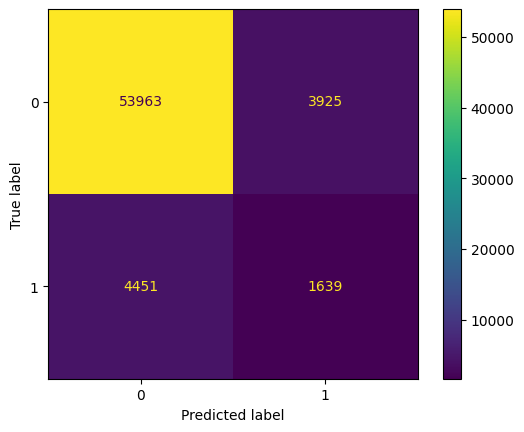

In [59]:
predictions=lgbm.predict(X_test)
roc_auc_= roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])
print('ROC_AUC=',roc_auc_)
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()
